In [68]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-01-09 18:54:13--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolvendo lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3030::ac43:d5a6, 2606:4700:3031::6815:17d2, 104.21.23.210, ...
Conectando-se a lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3030::ac43:d5a6|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 3421431 (3,3M) [text/csv]
Salvando em: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3,26M  3,91MB/s    em 0,8s    

2024-01-09 18:54:15 (3,91 MB/s) - ‘AirlineTweets.csv’ salvo [3421431/3421431]



In [6]:
df = pd.read_csv('AirlineTweets.csv')

In [7]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df = df[['airline_sentiment', 'text']].copy()

In [9]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


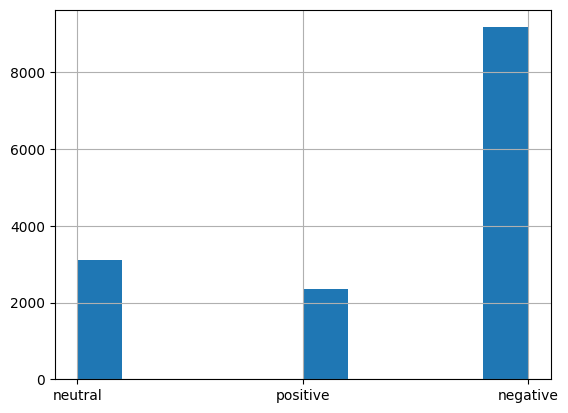

In [13]:
df['airline_sentiment'].hist();

In [50]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [51]:
df

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,1
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,0
14637,neutral,@AmericanAir Please bring American Airlines to...,2
14638,negative,"@AmericanAir you have my money, you change my ...",0


In [52]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=None)

In [53]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
raw_dataset = load_dataset('csv', data_files = 'data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [55]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [56]:
split = raw_dataset['train'].train_test_split(test_size = 0.3, seed = 42)

In [57]:
split['train']['label']

[0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 2,


In [58]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [59]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation = True, padding = True)

In [60]:
tokenized_datasets = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [61]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [63]:
training_args = TrainingArguments(output_dir = 'training_dir',
                                  evaluation_strategy = 'epoch',
                                  save_strategy = 'epoch',
                                  num_train_epochs = 3,
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 64,
                                 )

In [64]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis = 1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average = 'macro')
    return {'accuracy': acc, 'f1': f1}

In [65]:
trainer = Trainer(model, training_args, train_dataset = tokenized_datasets['train'],
                  eval_dataset = tokenized_datasets['test'],
                  tokenizer = tokenizer,
                  compute_metrics = compute_metrics,
                 )

In [66]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.532600,0.447858,0.830601,0.767019
2,0.347000,0.479472,0.837432,0.775843
3,0.245800,0.660796,0.831284,0.779244


TrainOutput(global_step=1923, training_loss=0.32563225105908533, metrics={'train_runtime': 2567.3509, 'train_samples_per_second': 11.975, 'train_steps_per_second': 0.749, 'total_flos': 616501848765600.0, 'train_loss': 0.32563225105908533, 'epoch': 3.0})

In [67]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [72]:
savemodel = pipeline('text-classification', model ='training_dir/checkpoint-1282', device = 0)

In [73]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [74]:
test_pred = savemodel(split['test']['sentence'])

In [75]:
test_pred

[{'label': 'LABEL_1', 'score': 0.9402925968170166},
 {'label': 'LABEL_1', 'score': 0.9339015483856201},
 {'label': 'LABEL_1', 'score': 0.6446467638015747},
 {'label': 'LABEL_1', 'score': 0.7277564406394958},
 {'label': 'LABEL_2', 'score': 0.6399198770523071},
 {'label': 'LABEL_0', 'score': 0.9966277480125427},
 {'label': 'LABEL_2', 'score': 0.773303747177124},
 {'label': 'LABEL_2', 'score': 0.7252863049507141},
 {'label': 'LABEL_1', 'score': 0.7608031034469604},
 {'label': 'LABEL_0', 'score': 0.9969158172607422},
 {'label': 'LABEL_0', 'score': 0.9699137806892395},
 {'label': 'LABEL_0', 'score': 0.997328519821167},
 {'label': 'LABEL_1', 'score': 0.9735339283943176},
 {'label': 'LABEL_0', 'score': 0.9963141083717346},
 {'label': 'LABEL_2', 'score': 0.9713114500045776},
 {'label': 'LABEL_2', 'score': 0.4131220281124115},
 {'label': 'LABEL_0', 'score': 0.7344644665718079},
 {'label': 'LABEL_0', 'score': 0.9978154897689819},
 {'label': 'LABEL_0', 'score': 0.7004459500312805},
 {'label': 'LA

In [77]:
def get_label(d):
    return int(d['label'].split('_')[1])

In [78]:
test_pred = [get_label(d) for d in test_pred]

In [80]:
print('acc :', accuracy_score(split['test']['label'], test_pred))

acc : 0.837431693989071


In [81]:
print('f1 :', f1_score(split['test']['label'], test_pred, average = 'macro'))

f1 : 0.7758426190732358


In [87]:
def plot_cm(cm):
    classes = ['negative', 'positive', 'neutral']
    df_cm = pd.DataFrame(cm, index = classes, columns = classes)
    ax = sn.heatmap(df_cm, annot=True, fmt = 'g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Target')

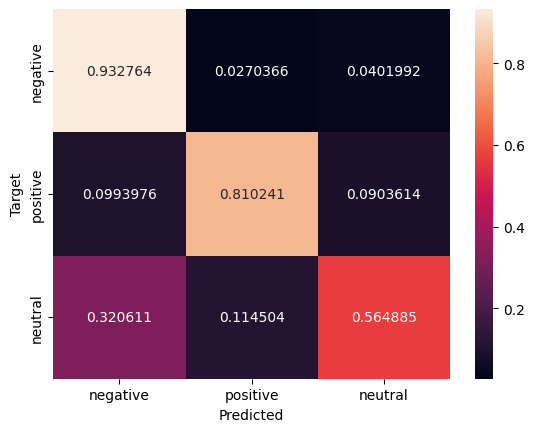

In [88]:
cm = confusion_matrix(split['test']['label'], test_pred, normalize = 'true')
plot_cm(cm)